In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
import matplotlib.pylab as pl
from pykalman import KalmanFilter
from statsmodels.tsa.api import VAR
from numpy.linalg import inv,pinv,det,cholesky
%run functions.ipynb

In [51]:
class DFM():
    def __init__(self, data, n_factor, max_lag_to_check):
        self.observations=data
        self.max_lag=max_lag_to_check
        self.n_factor=n_factor
        self.lag=None
        self.pca_loading=None
        self.pca_factor=None
        self.pca_common=None
        self.pca_var_param=None
        self.pca_obs_res_cov=None
        self.pca_factor_res_cov=None
        self.stacked_factor = None
        self.stacked_loading = None
        self.stacked_var_param=None
        self.obs_res_cov=None
        self.stacked_factor_res_cov=None
        self.loglikelyhood=None
        self.smoothed_state_cov=None
        self.pairwise_cov=None
        
    def to_state_space_rep(self): 
        '''use state space rep to trasfer VAR(P) to VAR(1)'''
        #put factors and their lags into one vector
        stacked_factor=np.array([np.roll(self.pca_factor,i,axis=1)[:,(self.lag-1):] for i in range(self.lag)])
        self.stacked_factor=stacked_factor.reshape(self.lag*self.n_factor,-1)
        
        #
        self.observations=self.observations[:,(self.lag-1):]
        
        #estimate dynamics of factors using VAR(1)
        model = VAR(self.stacked_factor.T)
        results = model.fit(1)
        self.stacked_var_param=results.coefs[0] #choose the lag-1 coefs
        
        # constrcut loading of state space model which is of the form [\Lambda 0 0]
        self.stacked_loading=np.concatenate((self.pca_loading
                                             ,np.zeros((self.pca_loading.shape[0],self.pca_loading.shape[1]*(self.lag-1))))
                                            ,axis=1)
        # construct residue matrix G
        G=np.concatenate((np.eye(self.n_factor),np.zeros((self.n_factor*(self.lag-1),self.n_factor))),axis=0)
        # construct covariance matrix for stacked factor residues
        self.stacked_factor_res_cov=G@self.pca_factor_res_cov@(G.T)
       
    def pca(self):
        '''pca estimation of DFM'''
        #calculate loading and factor using pca
        self.pca_loading,self.pca_factor=calculate_pca(self.observations,self.n_factor)
        
        #calculate common part
        self.pca_common=self.pca_loading@self.pca_factor
        
        #calculate observation residue
        obs_res=self.observations-self.pca_common
        
        #calculate observation residue covariance matrix
        self.obs_res_cov=np.cov(obs_res)
        
        #fit factor with VAR
        model = VAR(self.pca_factor.T)
        
        #select and save lag number
        results = model.fit(maxlags=self.max_lag, ic='aic')
        self.lag=results.k_ar
        
        #save dynamic matrix
        self.pca_var_param=results.coefs
        
        #calculate factor residue and its covariance matrix
        factor_resid=results.resid  #(n_time-lag,n_factor)
        self.pca_factor_res_cov=np.cov(factor_resid.T)
    
    def pairwise_covariance(self, smoothed_state_covariances,kalman_smoothing_gain):
    
        """
        Calculate covariance between hidden states at `t` and `t-1` for
        all time step pairs

        Parameters
        ----------
        smoothed_state_covariances : [n_timesteps, n_dim_state, n_dim_state] array
            covariance of hidden state given all observations
        kalman_smoothing_gain : [n_timesteps-1, n_dim_state, n_dim_state]
            Correction matrices from Kalman Smoothing
        Returns
        -------
        pairwise_covariances : [n_timesteps, n_dim_state, n_dim_state] array
            Covariance between hidden states at times t and t-1 for t =
            [1...n_timesteps-1].  Time 0 is ignored.
        """

        n_timesteps, n_dim_state, _ = smoothed_state_covariances.shape
        pairwise_covariances = np.zeros((n_timesteps, n_dim_state, n_dim_state))
        for t in range(1, n_timesteps):
            pairwise_covariances[t] = (
                np.dot(smoothed_state_covariances[t],
                       kalman_smoothing_gain[t - 1].T)
            )

        return pairwise_covariances
    
    def em(self,max_iter=100,limit=1e-6):
        #print(self.factor_res_cov)
        #calculate current loglikelyhood
        #ll=[self.calc_loglikelyhood()]
        ll=[-np.inf]
        #do em
        for i in range(max_iter):
            self.e_step()
            #ll1.append(self.calc_loglikelyhood())
            #ll2.append(self.calc_loglikelyhood_2())

            self.m_step()
            
            #cache loglikelyhood
            #ll1.append(self.calc_loglikelyhood())
            ll.append(self.calc_loglikelyhood_2())
            #break when not improving
            if ll[-1]-ll[-2]<limit:
                break
        self.loglikelyhood=ll[-1]
        self.e_step()
        return ll
    
    def e_step(self):
    
        # initialize parameters
        transition_matrix = self.stacked_var_param
        observation_matrix = self.stacked_loading
        transition_covariance = self.stacked_factor_res_cov
        observation_covariance = self.obs_res_cov

        # e_step
        kf = KalmanFilter(
            transition_matrices=transition_matrix, observation_matrices=observation_matrix,
        observation_covariance=observation_covariance,transition_covariance=transition_covariance)

        #change input format
        observations=self.observations.T
        
        # estimate state with filtering and smoothing
        smoothed_state_mean,smoothed_state_covariances,smoothing_gain = kf.smooth(observations)
  
        # estimated mean and covariances [n_factor,n_time_step], [n_time_step,n_factor,n_factor]
        self.stacked_factor=smoothed_state_mean.T
        self.smoothed_state_cov=smoothed_state_covariances
        
        #estimated P_{t,t-1}|T
        self.pairwise_cov=self.pairwise_covariance(smoothed_state_covariances,smoothing_gain)

    def m_step(self):
        T=self.observations.shape[1]
        xF=self.observations@(self.stacked_factor.T)
        xx=self.observations@(self.observations.T)
        FF=self.stacked_factor@(self.stacked_factor.T)+self.smoothed_state_cov.sum(axis=0)
        #construct factor_{t-1}
        F_1=np.roll(self.stacked_factor,1,axis=1)
        F_1[:,0]=0
        FF_1=self.stacked_factor@(F_1.T)+self.pairwise_cov[1:].sum(axis=0)
        F_1F_1=F_1@(F_1.T)+self.smoothed_state_cov[:-1].sum(axis=0)
        
        F_plus=np.roll(self.stacked_factor,-1,axis=1)
        F_plus[:,-1]=0
        F_plus_F_plus=F_plus@F_plus.T+self.smoothed_state_cov[1:].sum(axis=0)
        #compute loading
        self.stacked_loading=xF@inv(FF)
        #compute dynamics matrix A
        self.stacked_var_param=FF_1@inv(F_1F_1)
        #compute obs_res_cov
        self.obs_res_cov=(xx-self.stacked_loading@(xF.T))/T
        #compute factor_res_cov
        self.stacked_factor_res_cov=(F_plus_F_plus-self.stacked_var_param@(FF_1.T))/(T-1)
        
    def calc_loglikelyhood(self):
        T=self.observations.shape[1]
        ll=[]
        for t in range(T): 
            predicted_observation_mean = self.stacked_loading@self.stacked_factor[:,t]
            predicted_observation_covariance = self.stacked_loading@self.smoothed_state_cov[t]@self.stacked_loading.T\
            +self.obs_res_cov
            for i in range(100):
                    try:
                        cv_chol = linalg.cholesky(predicted_observation_covariance \
                                                  + i*1e-7 * np.eye(len(predicted_observation_covariance)),lower=True)
                        break
                    except:
                        continue
            log_det = 2 * np.sum(np.log(np.diagonal(cv_chol)))
            #log_det=np.log(det(predicted_observation_covariance))
            error=(self.observations[:,t]-predicted_observation_mean).T@inv(predicted_observation_covariance)\
            @(self.observations[:,t]-predicted_observation_mean)
            print(log_det,error)
            ll.append(log_det+error)
        return -0.5*np.sum(ll)
    def calc_loglikelyhood_2(self):
        observation=self.observations.T
        n_timesteps=len(observation)
        loglikelihoods = np.zeros(len(observation))
        for t in range(n_timesteps):

            predicted_observation_mean = self.stacked_loading@self.stacked_factor[:,t]

            predicted_observation_covariance = self.stacked_loading@self.smoothed_state_cov[t]@self.stacked_loading.T+self.obs_res_cov
            loglikelihoods[t]=log_multivariate_normal_density(
                            observation[t][np.newaxis, :],
                            predicted_observation_mean[np.newaxis, :],
                            predicted_observation_covariance[np.newaxis, :, :])
        return np.sum(loglikelihoods)

In [67]:
X,Gamma,F=generate_test_data(20,100)

In [68]:
model=DFM(X,5,5)
model.pca()
model.to_state_space_rep()


In [69]:
ll=model.em(max_iter=1000)

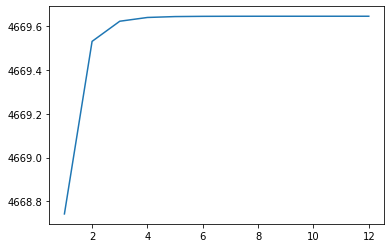

In [70]:
plt.plot(ll)

In [55]:
kf = KalmanFilter(
    transition_matrices=model.stacked_var_param,
    observation_matrices=model.stacked_loading,
    transition_covariance=model.stacked_factor_res_cov,
    observation_covariance=model.obs_res_cov,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
    ]
)

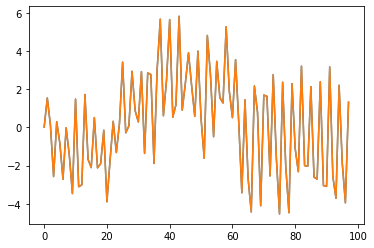

In [428]:
kf = KalmanFilter(
    transition_matrices=model.stacked_var_param,
    observation_matrices=model.stacked_loading,
    transition_covariance=model.stacked_factor_res_cov,
    observation_covariance=model.obs_res_cov,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
    ]
)
smoothed_state_mean,smoothed_state_covariances,smoothing_gain = kf.smooth(model.observations.T)
pl.plot(smoothed_state_mean[:,0])

kf = KalmanFilter(
    transition_matrices=model.stacked_var_param,
    observation_matrices=b,
    transition_covariance=model.stacked_factor_res_cov,
    observation_covariance=model.obs_res_cov,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
    ]
)
smoothed_state_mean,smoothed_state_covariances,smoothing_gain = kf.smooth(model.observations.T)
pl.plot(smoothed_state_mean[:,0])


1.0
1.0
1.0
1.0
1.0


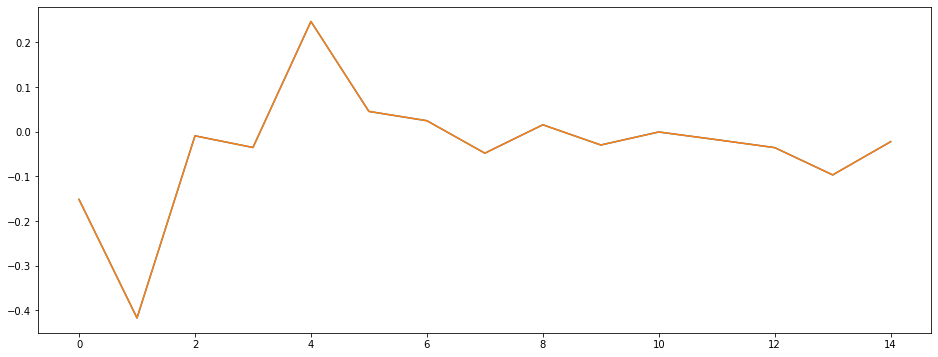

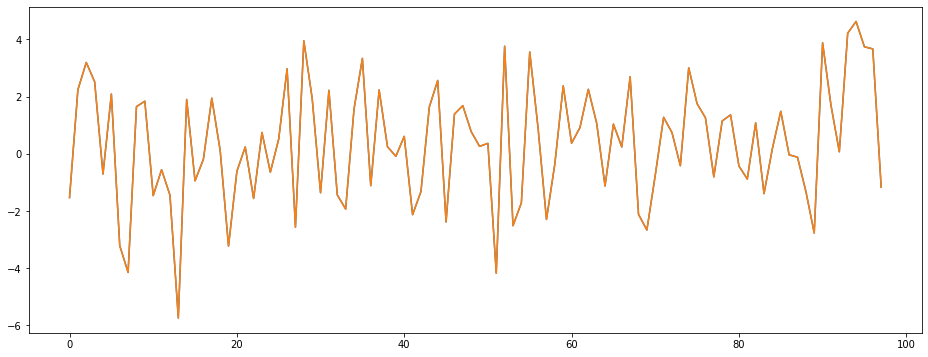

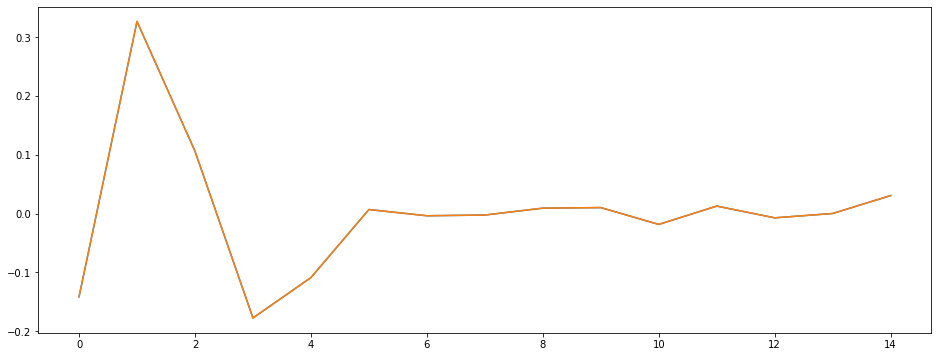

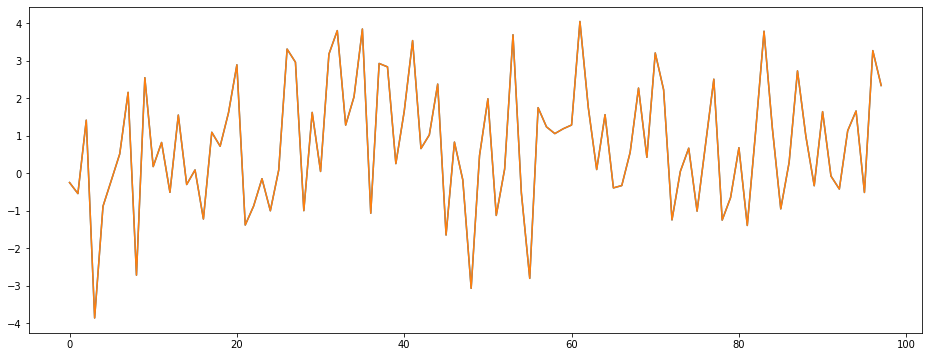

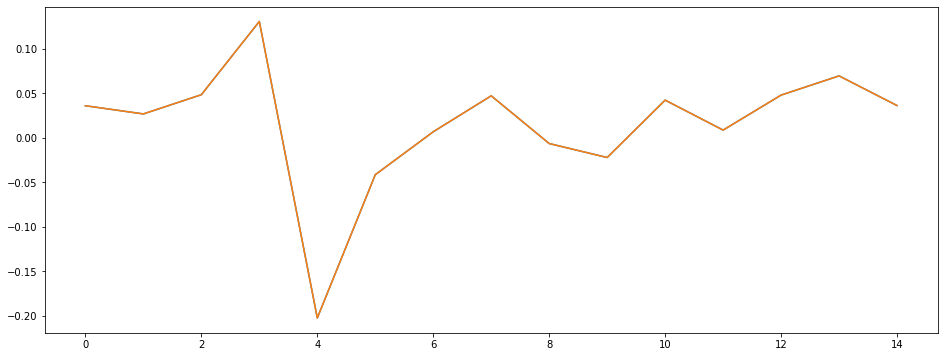

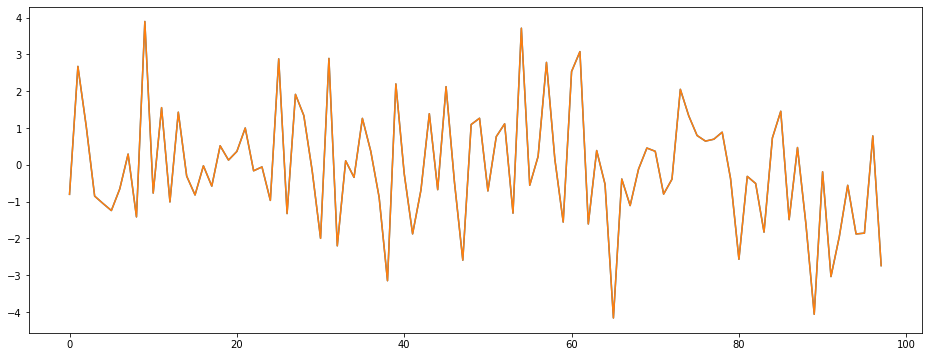

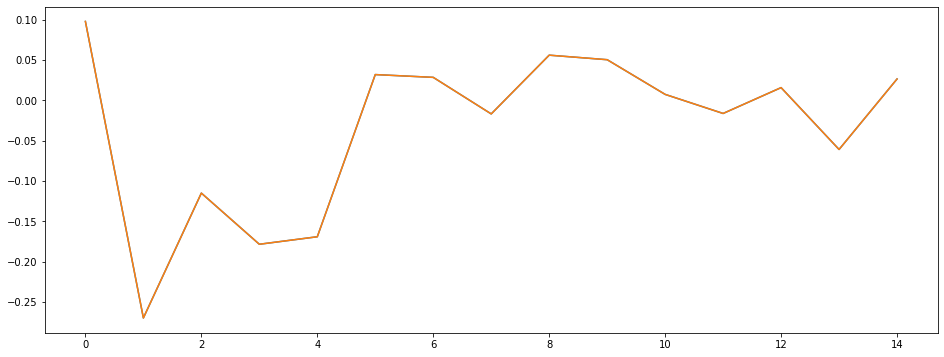

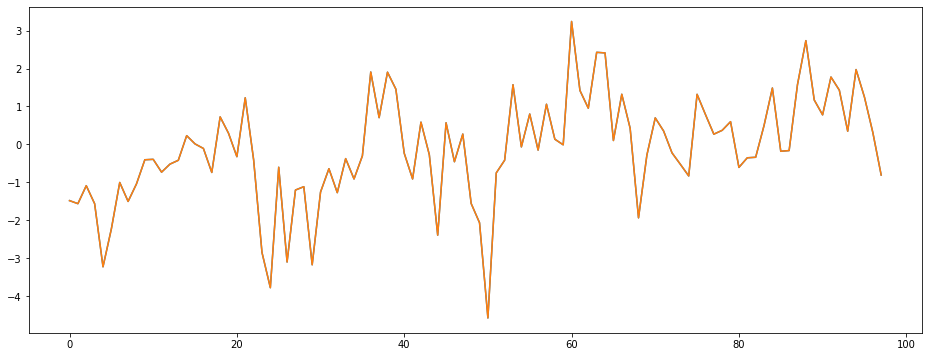

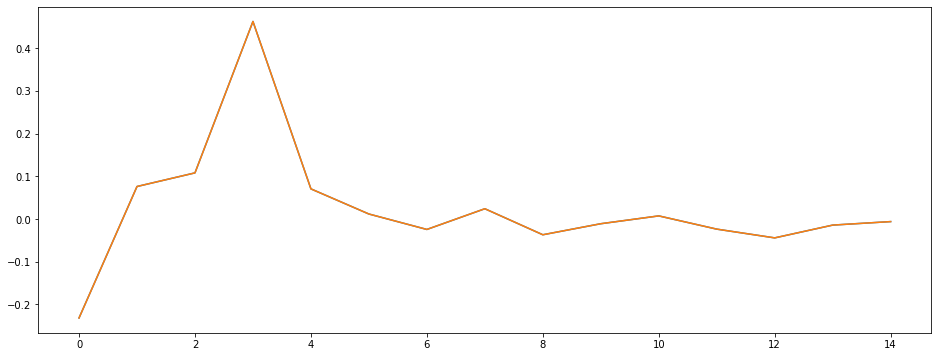

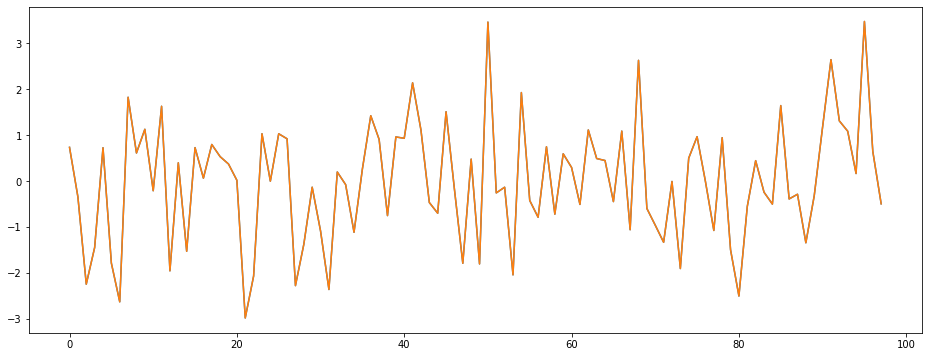

In [56]:
model.em(max_iter=1)
kf.em(X=model.observations.T, n_iter=1)
smoothed_state_mean,smoothed_state_covariances,smoothing_gain = kf.smooth(model.observations.T)
for i in range(5):
    pl.figure(figsize=(16, 6))
    pl.plot(model.stacked_loading[i])
    pl.plot(kf.observation_matrices[i])
    pl.figure(figsize=(16, 6))
    pl.plot(model.stacked_factor[i])
    pl.plot(smoothed_state_mean[:,i])
    print(r2_score(model.stacked_loading[i],kf.observation_matrices[i]))

1.0
1.0
1.0
1.0
1.0


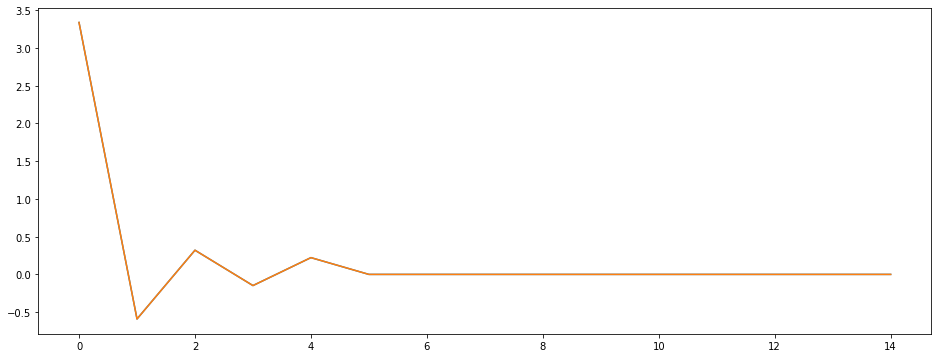

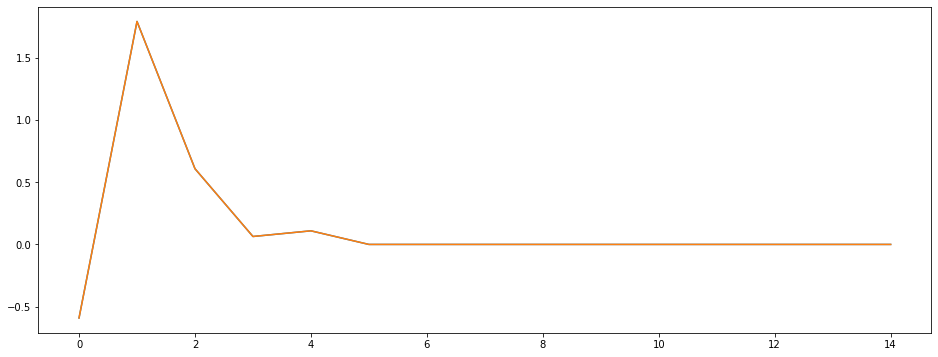

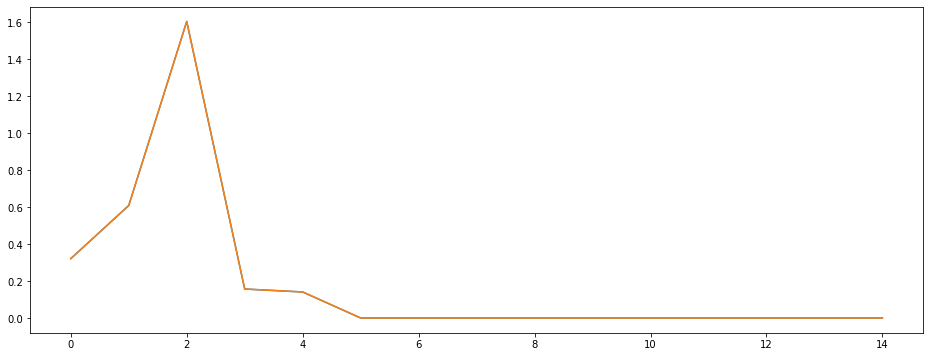

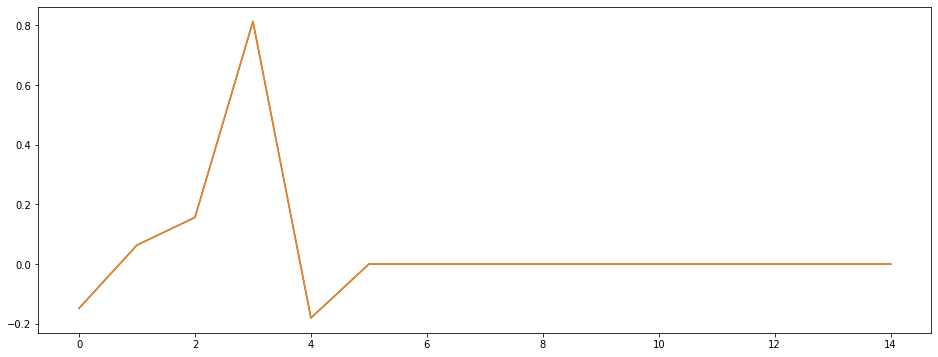

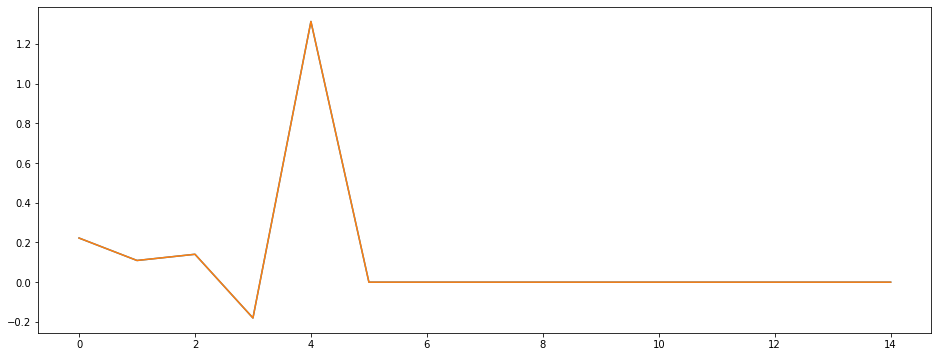

In [57]:
for i in range(5):
    pl.figure(figsize=(16, 6))
    pl.plot(model.stacked_factor_res_cov[i])
    pl.plot(kf.transition_covariance[i])
    print(r2_score(model.stacked_factor_res_cov[i],kf.transition_covariance[i]))

In [121]:
def calc_loglikelyhood_2(observation,stacked_loading,stacked_factor,smoothed_state_cov,obs_res_cov):
    n_timesteps=len(observation)
    loglikelihoods = np.zeros(len(observation))
    for t in range(n_timesteps):

        predicted_observation_mean = stacked_loading@stacked_factor[:,t]

        predicted_observation_covariance = stacked_loading@smoothed_state_cov[t]@stacked_loading.T+obs_res_cov
        loglikelihoods[t]=log_multivariate_normal_density(
                        observation[t][np.newaxis, :],
                        predicted_observation_mean[np.newaxis, :],
                        predicted_observation_covariance[np.newaxis, :, :])
    return np.sum(loglikelihoods)

0.9414676683987988 0.9414676683987725 0.9414676683987716
0.9248785111434581 0.9248785111434888 0.9248785111434892
0.8726708033701353 0.8726708033701313 0.8726708033701315
0.7893056496427323 0.7893056496428013 0.7893056496428025
0.8098334237501885 0.8098334237501791 0.8098334237501776


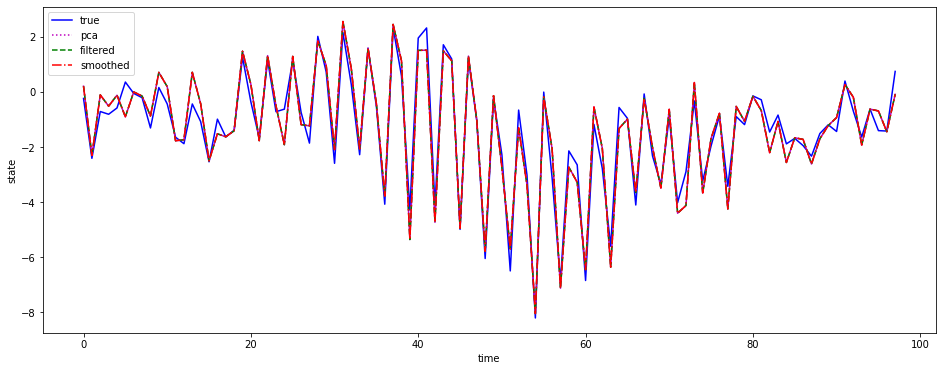

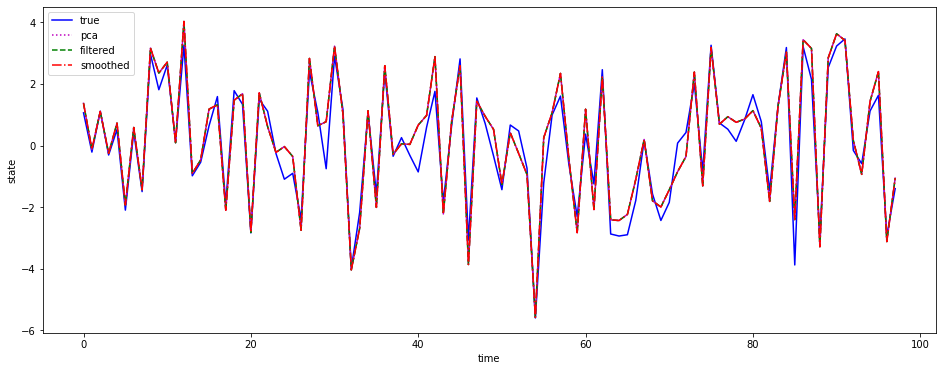

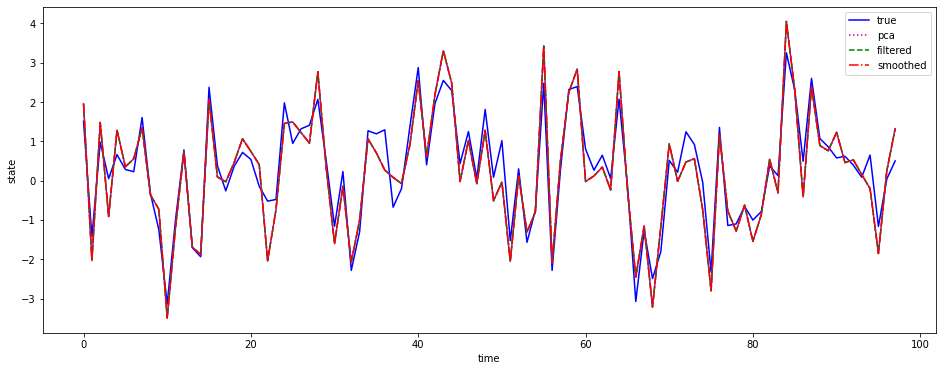

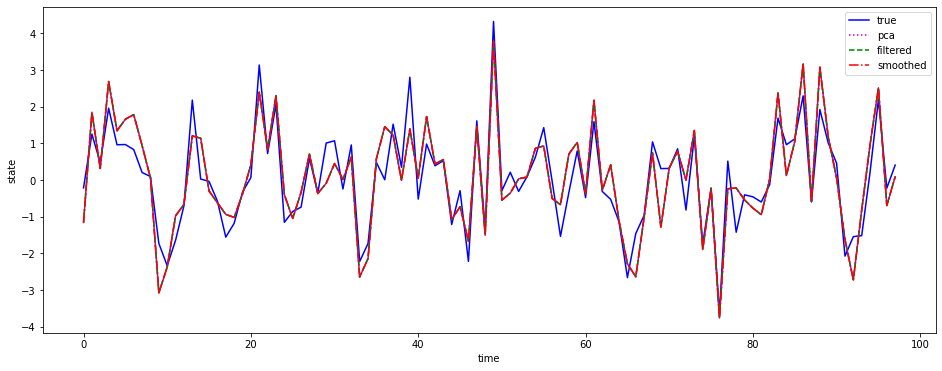

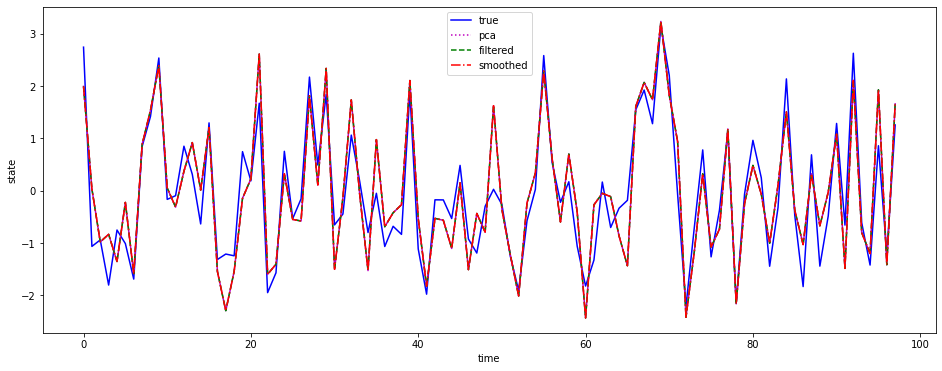

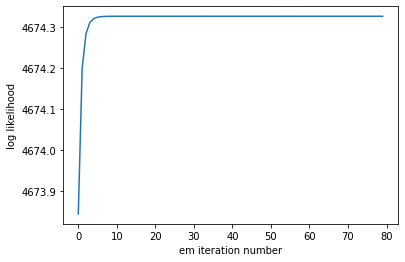

In [373]:
from pykalman import KalmanFilter

# Load data and initialize Kalman Filter

kf = KalmanFilter(
    transition_matrices=model.stacked_var_param,
    observation_matrices=model.stacked_loading,
    transition_covariance=model.stacked_factor_res_cov,
    observation_covariance=model.obs_res_cov,
    em_vars=[
      'transition_matrices', 'observation_matrices',
      'transition_covariance', 'observation_covariance',
    ]
)

# Learn good values for parameters named in `em_vars` using the EM algorithm
loglikelihoods = np.zeros(80)
for i in range(len(loglikelihoods)):
    kf = kf.em(X=model.observations.T, n_iter=1)
    #stacked_factor,stacked_factor_res_cov,pairwise_cov=kf.smooth(model.observations.T)
    stacked_factor,stacked_factor_res_cov=kf.filter(model.observations.T)
    loglikelihoods[i] = calc_loglikelyhood_2(model.observations.T,kf.observation_matrices,stacked_factor.T
                                             ,stacked_factor_res_cov,kf.observation_covariance)

# Estimate the state without using any observations.  This will let us see how
# good we could do if we ran blind.
n_dim_state = model.stacked_var_param.shape[0]
n_timesteps = model.observations.T.shape[0]
blind_state_estimates = np.zeros((n_timesteps, n_dim_state))
for t in range(n_timesteps - 1):
    if t == 0:
        blind_state_estimates[t] = kf.initial_state_mean
    blind_state_estimates[t + 1] = (
      np.dot(kf.transition_matrices, blind_state_estimates[t])
    )

# Estimate the hidden states using observations up to and including
# time t for t in [0...n_timesteps-1].  This method outputs the mean and
# covariance characterizing the Multivariate Normal distribution for
#   P(x_t | z_{1:t})
filtered_state_estimates = kf.filter(model.observations.T)[0]

# Estimate the hidden states using all observations.  These estimates
# will be 'smoother' (and are to be preferred) to those produced by
# simply filtering as they are made with later observations in mind.
# Probabilistically, this method produces the mean and covariance
# characterizing,
#    P(x_t | z_{1:n_timesteps})
smoothed_state_estimates = kf.smooth(model.observations.T)[0]

# Draw the true, blind,e filtered, and smoothed state estimates for all 5
# dimensions.
for i in range(5):
    pl.figure(figsize=(16, 6))
    if r2_score(F[i][2:], smoothed_state_estimates[:,i])<r2_score(F[i][2:], -smoothed_state_estimates[:,i]):
            F[i][2:]=-F[i][2:]
    print(r2_score(F[i][2:], model.pca_factor[i,2:]),r2_score(F[i][2:], filtered_state_estimates[:,i]),r2_score(F[i][2:], smoothed_state_estimates[:,i]))
    lines_true = pl.plot(F[i][2:], linestyle='-', color='b')
    lines_pca = pl.plot(model.pca_factor[i,2:], color='m')
    lines_filt = pl.plot(filtered_state_estimates[:,i], linestyle='--', color='g')
    lines_smooth = pl.plot(smoothed_state_estimates[:,i], linestyle='-.', color='r')
    pl.legend(
        (lines_true[0], lines_blind[0], lines_filt[0], lines_smooth[0]),
        ('true', 'pca', 'filtered', 'smoothed')
    )
    pl.xlabel('time')
    pl.ylabel('state')


# Draw log likelihood of observations as a function of EM iteration number.
# Notice how it is increasing (this is guaranteed by the EM algorithm)
pl.figure()
pl.plot(loglikelihoods)
pl.xlabel('em iteration number')
pl.ylabel('log likelihood')
pl.show()

0.9414676683987988 0.9414676683988488 0.9414676683987716
0.9248785111434581 0.924878511143442 0.9248785111434892
0.8726708033701353 0.8726708033701327 0.8726708033701315
0.7893056496427323 0.7893056496428463 0.7893056496428025
0.8098334237501885 0.8098334237502004 0.8098334237501776


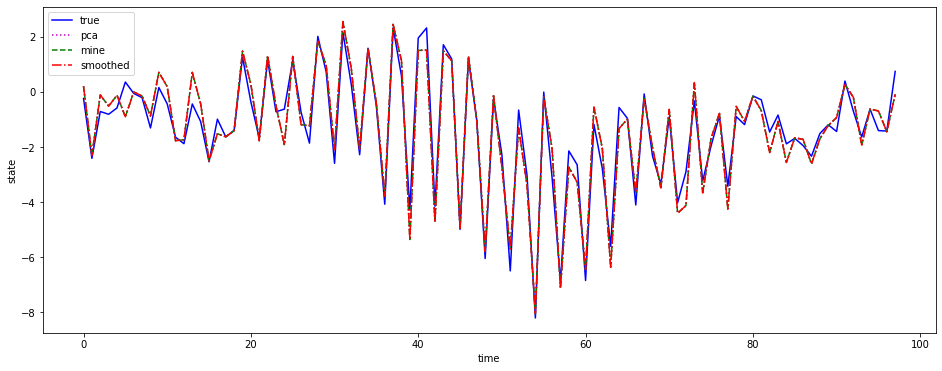

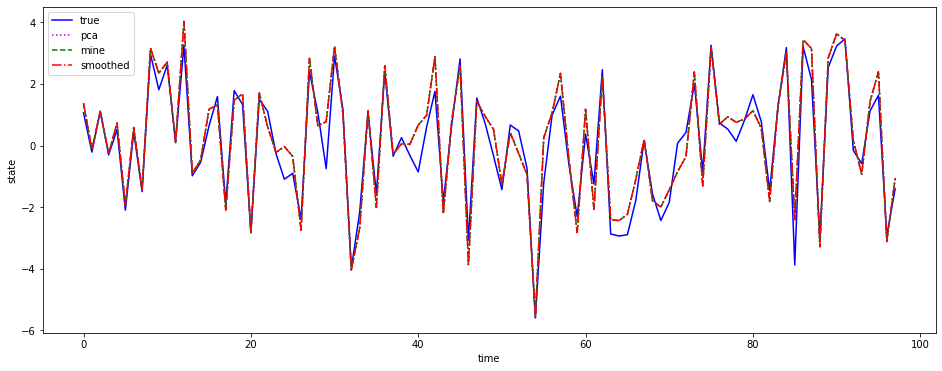

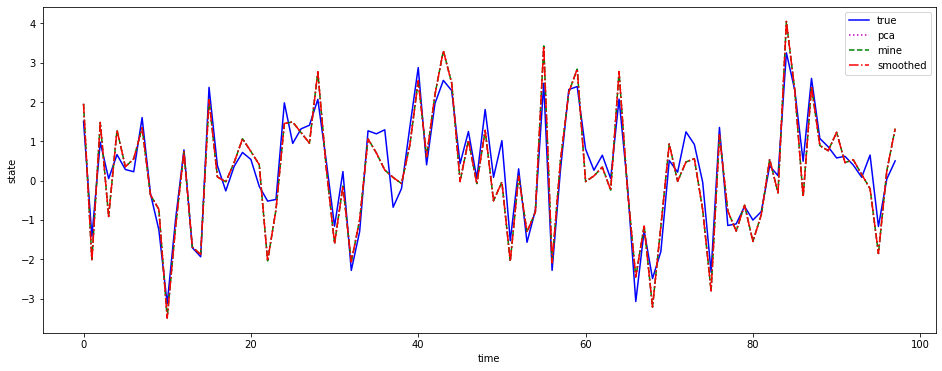

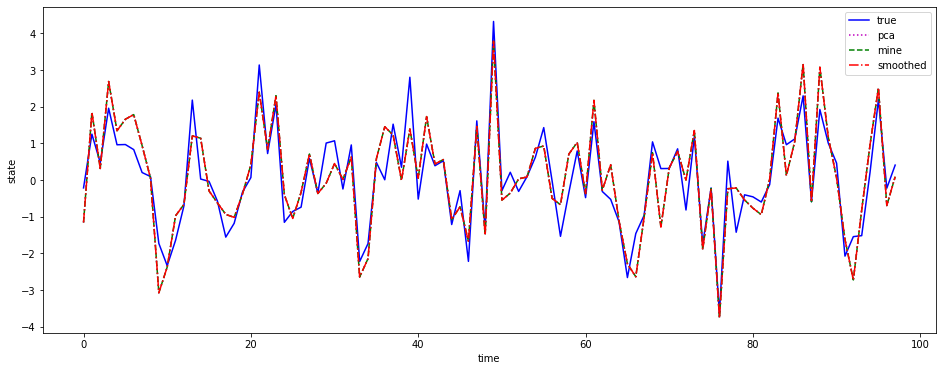

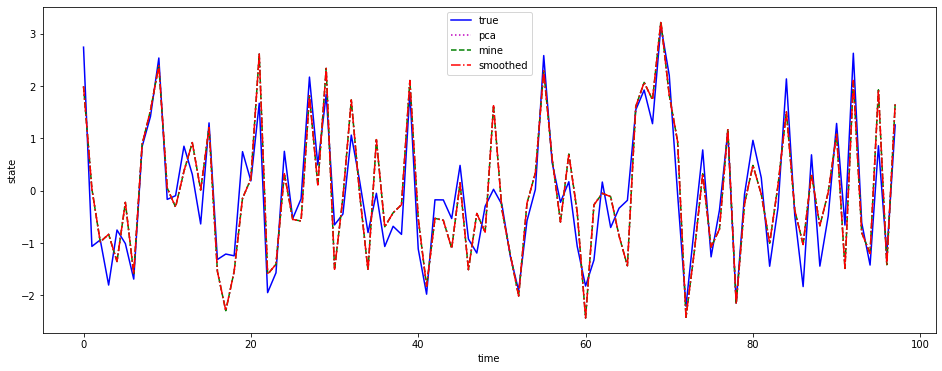

In [370]:
for i in range(5):
    pl.figure(figsize=(16, 6))
    if r2_score(F[i][2:], smoothed_state_estimates[:,i])<r2_score(F[i][2:], -smoothed_state_estimates[:,i]):
            F[i][2:]=-F[i][2:]
    print(r2_score(F[i][2:], model.pca_factor[i,2:]),r2_score(F[i][2:], model.stacked_factor[i]),r2_score(F[i][2:], smoothed_state_estimates[:,i]))
    lines_true = pl.plot(F[i][2:], linestyle='-', color='b')
    lines_pca = pl.plot(model.pca_factor[i,2:], linestyle=':', color='m')
    lines_mine = pl.plot(model.stacked_factor[i], linestyle='--', color='g')
    lines_smooth = pl.plot(smoothed_state_estimates[:,i], linestyle='-.', color='r')
    pl.legend(
        (lines_true[0], lines_blind[0], lines_filt[0], lines_smooth[0]),
        ('true', 'pca', 'mine', 'smoothed')
    )
    pl.xlabel('time')
    pl.ylabel('state')

    